# Decoding Responsivity (imbalanced learn)
**Can we predict whether a stimulus will be detected or not based on neuron's responsivity ?**

Célien Vandromme
18/04/2024

---

In [123]:
import numpy as np
import pandas as pd


import percephone.core.recording as pc
import os
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import imblearn as imb

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')
fontsize = 20

In [91]:
directory = "C:/Users/cvandromme/Desktop/Data/"
roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    rec.peak_delay_amp()
    return rec


workers = cpu_count()
pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


In [259]:
def resp_heatmap(record_dict, sort=False):
    if sort:
        X_train_true = record_dict["X_train"][record_dict["y_train"] == True]
        y_train_true = np.ones(X_train_true.shape[0], dtype=bool)
        X_train_false = record_dict["X_train"][record_dict["y_train"] == False]
        y_train_false = np.zeros(X_train_false.shape[0], dtype=bool)
        X_new = record_dict["X_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        y_new = record_dict["y_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        X = np.row_stack((X_train_true, X_train_false, X_new))
        y = np.append(y_train_true, np.append(y_train_false, y_new))
    else:
        X = record_dict["X_bal"]
        y = record_dict["y_bal"]

    plt.figure(figsize=(12, 6))
    sns.heatmap(X.T, cmap='inferno', xticklabels=y, cbar_kws={'label': 'Responsivity'})
    plt.axvline(x=record_dict["X_train"].shape[0], color="black", linewidth=1)
    if sort:
        plt.axvline(x=X_train_true.shape[0], color="black", linewidth=1, linestyle='dashed')
    plt.title(f"{record_dict["filename"]}({record_dict["genotype"]}) Neuron Responses to Stimuli")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xlabel("Detected stimulation")
    plt.ylabel("Neurons")
    plt.show()

In [93]:
def get_rec_info(rec, parameter, exc_neurons=True, inh_neurons=False):
    result = {}
    result["genotype"] = rec.genotype
    result["filename"] = rec.filename
    result["y"] = rec.detected_stim
    if exc_neurons and inh_neurons:
        result["X"] = np.row_stack((rec.matrices["EXC"][parameter], rec.matrices["INH"][parameter])).T
        result["neurons"] = "EXC & INH"
    elif exc_neurons:
        result["X"] = rec.matrices["EXC"][parameter].T
        result["neurons"] = "EXC"
    elif inh_neurons:
        result["X"] = rec.matrices["INH"][parameter].T
        result["neurons"] = "INH"
    return result

In [174]:
def split_data(record_dict, train_ratio=0.8, stratify=False, seed=None):
    if stratify:
        record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                        train_size=train_ratio,
                                                                                                                        stratify=record_dict["y"],
                                                                                                                        random_state=seed)
    else:
        record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                        train_size=train_ratio,
                                                                                                                        stratify=None,
                                                                                                                        random_state=seed)
    return record_dict

In [180]:
def resample(record_dict, resampler):
    record_dict["X_bal"], record_dict["y_bal"] = resampler.fit_resample(record_dict["X_train"], record_dict["y_train"])
    return record_dict

In [236]:
def apply_model(model, parameter, resampler=None, exc_neurons=True, inh_neurons=True, train_ratio=0.8, stratify=True, cv=10, seed=None):
    mean_cv_scores = []
    accuracies = []
    sensitivities = []
    specificities = []
    genotype_list = []
    models_dict = {}
    
    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(15, 10), sharex=True)
    i_wt = 0
    i_ko = 0
        
    for rec in recs.values():
        record = get_rec_info(rec, parameter, exc_neurons=exc_neurons, inh_neurons=inh_neurons)
        record = split_data(record, train_ratio=train_ratio, stratify=stratify, seed=seed)
        test_size = record["y_test"].shape[0]
        
        if resampler is not None:
            record = resample(record, resampler)
            new_samples = record["y_bal"].shape[0] - record["y_train"].shape[0]
            model.fit(record["X_bal"], record["y_bal"])
            cv_scores = cross_val_score(model, record["X_bal"], record["y_bal"], cv=cv)
        else:
            new_samples = 0
            model.fit(record["X_train"], record["y_train"])
            cv_scores = cross_val_score(model, record["X_train"], record["y_train"], cv=cv)
        
        # Saving model for plotting the weights
        models_dict[f"{record["filename"]} ({record["genotype"]})"] = copy.copy(model)
        
        # Cross-validation
        mean_cv_scores.append(cv_scores.mean())
        genotype_list.append(record["genotype"])
        
        # Metrics on test data
        y_pred = model.predict(record["X_test"])
        conf_matrix = confusion_matrix(record["y_test"], y_pred)
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        # Boxplot of each recording
        if rec.genotype == "WT":
            i = copy.copy(i_wt)
            j = 0
            i_wt += 1
        else:
            i = copy.copy(i_ko)
            j = 1
            i_ko += 1
        
        ax[i, j].boxplot(cv_scores, vert=False, widths=.5)
        ax[i, j].scatter(cv_scores, np.ones(cv), s=10)
        ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[N:{new_samples} T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({accuracy:.1%}) Sp({specificity:.1%}) Se({sensitivity:.1%})", size=10)
        ax[i, j].spines["left"].set_visible(False)
    plt.suptitle(f"Decoding {parameter} [{resampler}/{model}] - Train size: {train_ratio:.1%} - CV: {cv} fold")
    plt.show()
    
    # Mean boxplots
    df = pd.DataFrame({
        'genotype': genotype_list,
        'cv_score': mean_cv_scores,
        'sensitivity': sensitivities,
        'specificity': specificities,
        'accuracy': accuracies
    })
    df_melted = df.melt(id_vars="genotype", var_name="metric", value_name="value")
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='genotype', y='value', hue='metric', data=df_melted)
    plt.title(f"Metrics for each group [{resampler}/{model}]")
    plt.show()

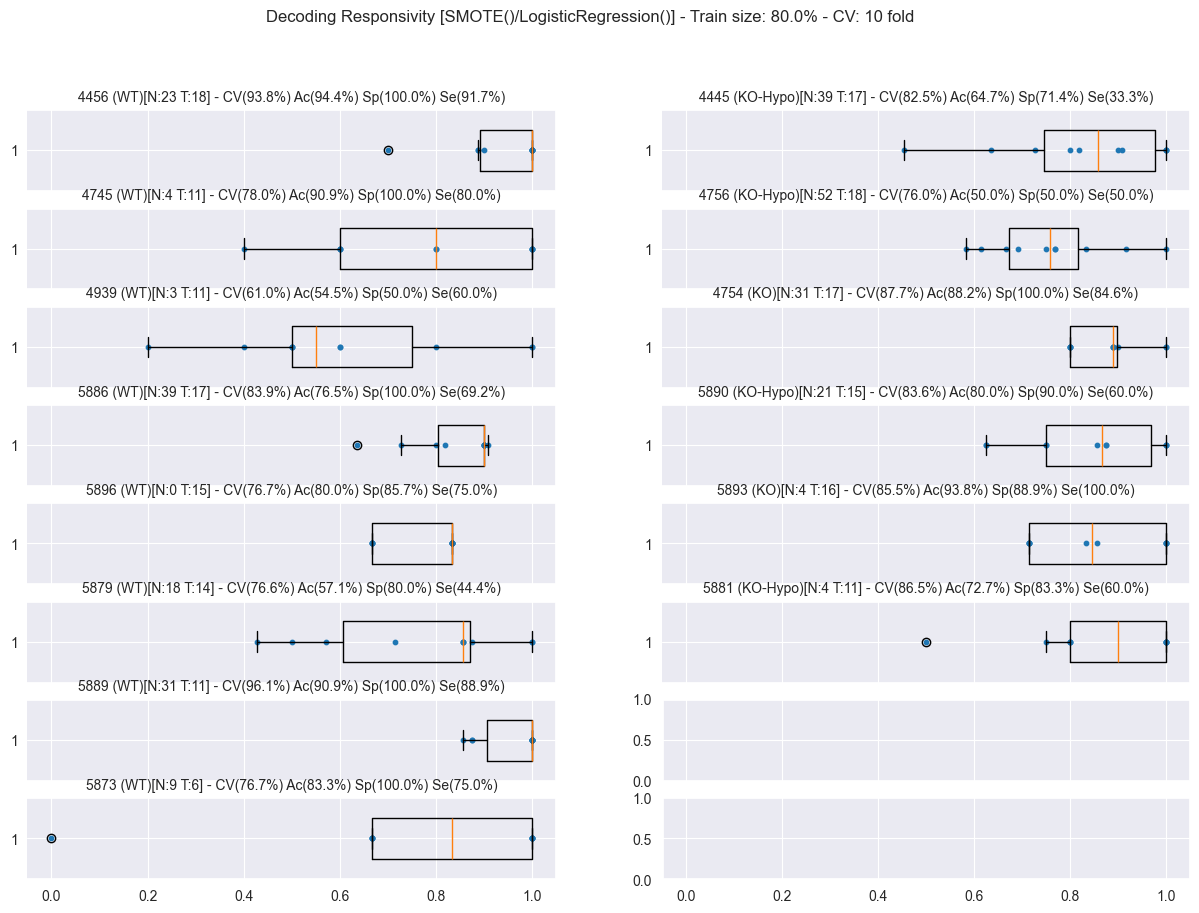

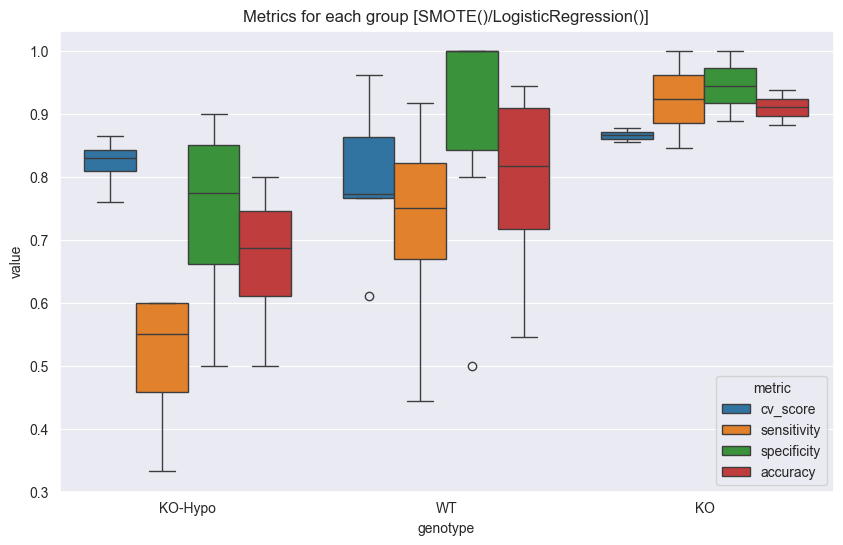

In [250]:
seed = 42

# Models
dum = DummyClassifier()
lr = LogisticRegression(penalty="l2")

# Resamplers
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=0.2)
smote = imb.over_sampling.SMOTE(sampling_strategy='auto')
adasyn = imb.over_sampling.ADASYN(sampling_strategy='auto')

apply_model(lr, "Responsivity", resampler=smote, exc_neurons=True, inh_neurons=True, train_ratio=0.8, cv=10, stratify=True, seed=seed)

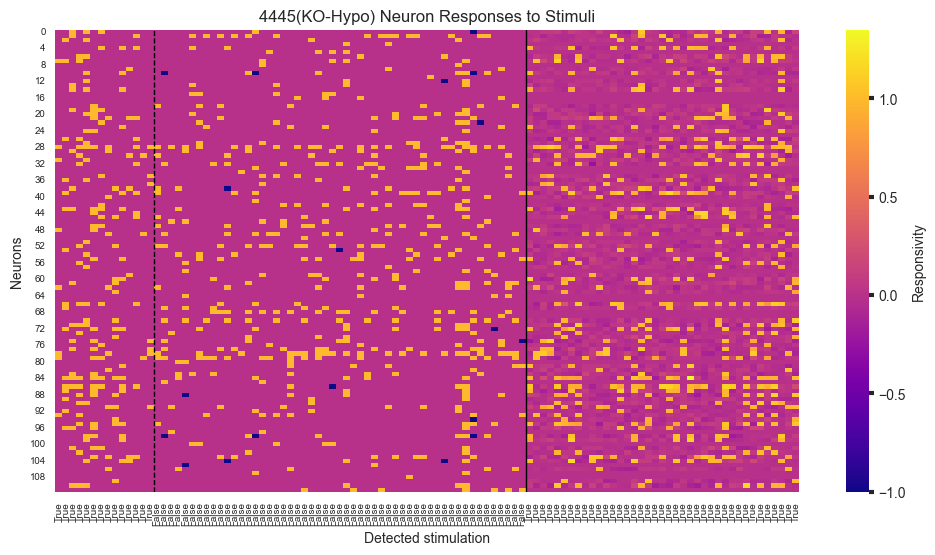

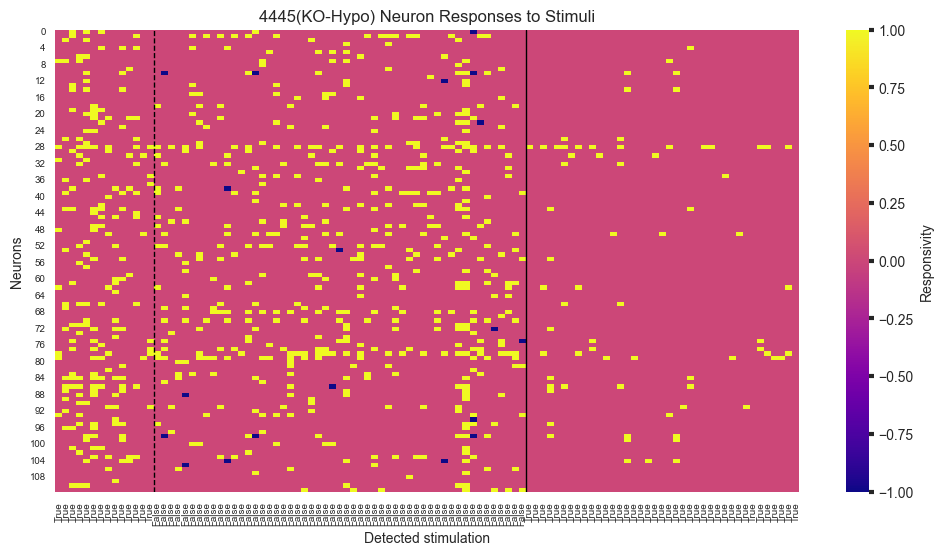

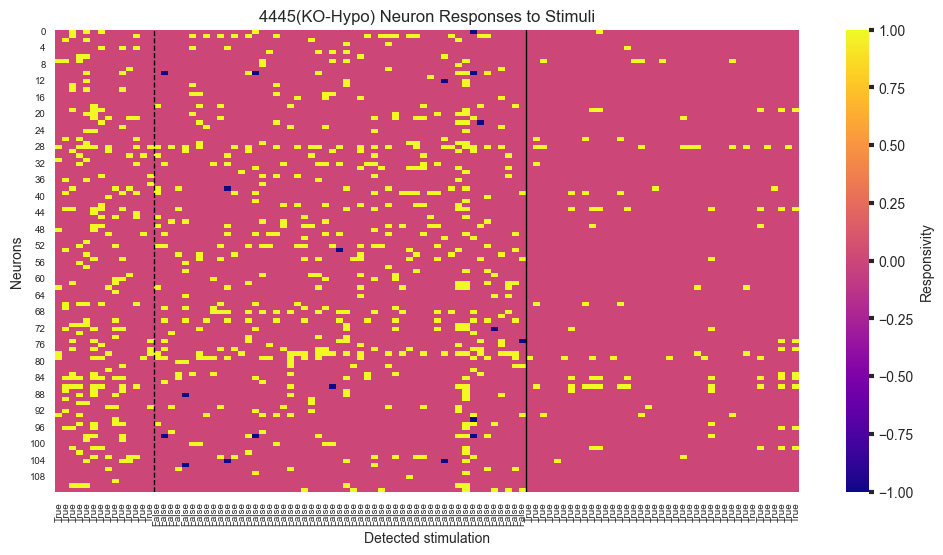

2343739268288 2343773295488 2343758051968


In [258]:
rec = recs[4445]
test = get_rec_info(rec, "Responsivity", exc_neurons=True, inh_neurons=True)
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=0.2)
bd_smote = imb.over_sampling.BorderlineSMOTE(sampling_strategy='auto')
test = split_data(test, train_ratio=0.8, stratify=True)

test_3 = resample(test, ros)
test = resample(copy.copy(test), smote)
test_2 = resample(copy.copy(test), bd_smote)
resp_heatmap(test_3, sort=True)
resp_heatmap(test, sort=True)
resp_heatmap(test_2, sort=True)
print(id(test_3), id(test), id(test_2))